# Testing Negativ Binomail and Gamma loss Data fitting and parameter estimation within PyGOM

This is an example of parameter fitting with an SIR model.

In [1]:
from pygom import Transition, TransitionType, SimulateOde, SquareLoss, PoissonLoss, NormalLoss, NegBinomLoss, GammaLoss
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import copy

from scipy.optimize import minimize

In [2]:
# Generate some data for fitting

# Standard SIR model with 2 parameters
# construct model 
states = ['S', 'I', 'R']
params = ['beta', 'gamma', 'N']
transitions = [Transition(origin='S', destination='I', equation='beta*S*I/N', 
                          transition_type=TransitionType.T),
               Transition(origin='I', destination='R', equation='gamma*I', 
                          transition_type=TransitionType.T)]
model = SimulateOde(states, params, transition=transitions)

In [3]:
# initial conditions 
N = 1e6
in_inf = 2
init_state = [N - in_inf, in_inf, 0.0]
# time 
t = np.arange (0 , 51 , 0.25)
# deterministic parameter values
param_evals = [('beta', 3.6), ('gamma', 0.2), ('N', N)]
model.parameters = param_evals
model.initial_values = (init_state, t[0])

In [4]:
# run 1 simulations
data = model.integrate(t[1:])

Data over 100 days, with observations from every day for infected and removed populations.

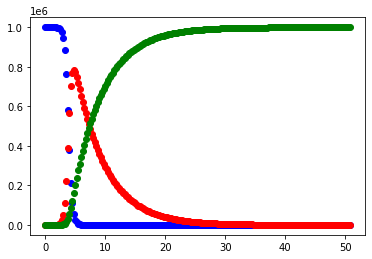

In [5]:
plt.plot(t,data[:,0], 'bo') # infected observations
plt.plot(t,data[:,1], 'ro') # infected observations
plt.plot(t,data[:,2], 'go') # removed observations (recoverd/died)

plt.show()

# Adding random noise to produce Continuos Data

Our data needs to be have some noise so lets put it through a function for randomisation using the gamma distribution.

In [6]:
def runif_noise(x,noise_prop):
    '''
    Takes x and adds noise on the uniform distribution.
    '''
    i_len,j_len = x.shape
    ans = copy.deepcopy(x)
    for i in range(i_len):
        for j in range(j_len):
            ans[i,j]=x[i,j] + x[i,j]*np.random.uniform(low=-noise_prop,high=noise_prop,size=1)
                   
    return ans

In [7]:
data[0,:]

array([9.99998e+05, 2.00000e+00, 0.00000e+00])

In [8]:
noised_data = runif_noise(data,1/3)
#we stil want the first row from data
noised_data[0,:] = data[0,:]
(noised_data-data)/data

<ipython-input-8-74bf619963ac>:4: RuntimeWarning: invalid value encountered in true_divide
  (noised_data-data)/data


array([[ 0.00000000e+00,  0.00000000e+00,             nan],
       [-3.21943456e-01,  1.85865527e-01, -1.13217774e-01],
       [-2.10940831e-01, -1.40000086e-01,  3.21150841e-01],
       [ 1.81602995e-01,  1.28076820e-02,  2.49787871e-01],
       [-1.99910787e-01, -3.21987422e-01,  6.59265374e-02],
       [-3.07353570e-01, -2.27188132e-01,  2.17562011e-01],
       [-5.63337347e-02, -1.89013740e-01,  2.84964767e-02],
       [ 2.31501967e-01,  6.14997028e-02, -2.35895637e-01],
       [ 2.23927782e-01, -1.01405449e-01, -1.98699260e-01],
       [ 2.48735438e-01, -3.53640373e-02,  1.67031470e-01],
       [ 4.94412026e-02, -1.52057161e-01,  2.09835766e-01],
       [-2.06776227e-01,  3.13201462e-01, -4.29291297e-02],
       [ 2.46433170e-02, -2.84114224e-01,  3.25711119e-03],
       [ 1.92155506e-01,  2.17675626e-01,  5.62946687e-02],
       [-1.44069462e-01,  1.35347749e-01, -1.82909871e-01],
       [-8.29226910e-02,  3.23393603e-01, -2.81718008e-01],
       [-3.76928728e-02,  3.23038547e-02

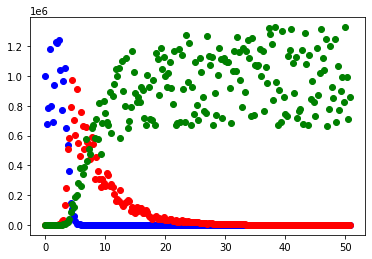

In [9]:
plt.plot(t,noised_data[:,0], 'bo') # infected observations
plt.plot(t,noised_data[:,1], 'ro') # infected observations
plt.plot(t,noised_data[:,2], 'go') # removed observations (recoverd/died)

plt.show()

We provide a guess for $\beta$ and $\gamma$. 

This example assumes we have information about the infected and removed population, up to 50 days of the epidemic.


In [10]:
data_to_fit = noised_data[:,1:3]
data_to_fit = data_to_fit[1::,:]
data_to_fit

array([[5.54899714e+00, 1.39761571e-01],
       [9.41509648e+00, 6.95380093e-01],
       [2.59415887e+01, 1.73602161e+00],
       [4.06294543e+01, 3.63207199e+00],
       [1.08339867e+02, 9.89807619e+00],
       [2.65942008e+02, 1.97219908e+01],
       [8.14010192e+02, 3.43927387e+01],
       [1.61036450e+03, 8.44615745e+01],
       [4.03372942e+03, 2.87600545e+02],
       [8.24405119e+03, 6.95570046e+02],
       [2.94412965e+04, 1.27820655e+03],
       [3.63262375e+04, 3.08314488e+03],
       [1.34300664e+05, 7.31638055e+03],
       [2.51120961e+05, 1.22282810e+04],
       [5.12397402e+05, 2.15432773e+04],
       [5.85616873e+05, 3.84847695e+04],
       [7.90205922e+05, 8.36926709e+04],
       [9.74797129e+05, 1.37447113e+05],
       [7.07757082e+05, 1.17346978e+05],
       [6.03556137e+05, 1.89433078e+05],
       [9.13909621e+05, 1.99048484e+05],
       [5.48929799e+05, 2.79399602e+05],
       [4.62040519e+05, 3.83327390e+05],
       [7.61326355e+05, 2.58855593e+05],
       [6.622874

## Fitting Normal loss

In [11]:
param_evals

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

In [12]:
# Initial guess of parameters, and bounding constraints
theta = [3, 0.15,1e6]
boxBounds = [(2,5),(0.0,1.0),(1e6,1e6)]

objSIR = NormalLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

In [13]:
objSIR

NormalLoss([3.0, 0.15, 1000000.0], SimulateOde([ODEVariable('S', 'S', None, True), ODEVariable('I', 'I', None, True), ODEVariable('R', 'R', None, True)], [ODEVariable('beta', 'beta', None, True), ODEVariable('gamma', 'gamma', None, True), ODEVariable('N', 'N', None, True)], [], [Transition('S', 'beta*S*I/N', 'T', 'I', None, None), Transition('I', 'gamma*I', 'T', 'R', None, None)], [], []).setParameters({'beta': 3.6, 'gamma': 0.2, 'N': 1000000.0}), [999998.0, 2.0, 0.0], 0.0, [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25, 15.5, 15.75, 16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, 17.75, 18.0, 18.25, 18.5, 18.75, 19.0, 19.25, 19.5, 19.75, 20.0, 20.25, 20.5, 20.75, 21.0, 21.25, 21.5, 

In [14]:
objSIR.cost()

4909533605860.806

In [15]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 3257054048571.9863
 hess_inv: array([[ 5.18410500e-11, -2.54658445e-12,  1.27206329e-05],
       [-2.54658442e-12,  1.49261473e-13, -6.12083782e-07],
       [ 1.27206329e-05, -6.12083790e-07,  3.12906462e+00]])
      jac: array([-1.10600741e+00, -4.43260288e+00,  4.08760083e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 12
     njev: 38
   status: 2
  success: False
        x: array([5.52375636e+00, 2.03086137e-01, 1.49373372e+06])


In [16]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 3257054048571.9043
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.79695180e+01, -1.47147132e+03,  3.25305614e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 9
     njev: 14
   status: 0
  success: True
        x: array([3.69795251e+00, 2.03086137e-01, 1.00000000e+06])


In [17]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## Fitting Gamma loss

In [18]:
# Initial guess of parameters, and bounding constraints
objSIR = GammaLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=data_to_fit, state_name=['I','R'])

In [19]:
objSIR.sensitivity()

array([-5.77968064e+02, -6.98915605e+03,  1.73390419e-03])

In [20]:
objSIR.cost()

5062.059868394187

In [21]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 4717.565272474467
 hess_inv: array([[ 3.84423633e-03, -3.01340148e-05,  1.56049513e-06],
       [-3.01340148e-05,  3.82956903e-06,  1.49977083e-08],
       [ 1.56049513e-06,  1.49977083e-08,  1.00000000e+00]])
      jac: array([ 8.12454287e-07, -3.28990725e-04, -2.91902226e-12])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 57
      nit: 10
     njev: 46
   status: 2
  success: False
        x: array([3.59284491e+00, 1.99665537e-01, 1.00000000e+06])


In [22]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev7+g126fc99.d20200624-py3.8-win-amd64.egg\pygom\utilR\distn.py:108: RuntimeWarning: invalid value encountered in log
  logpdf_p3= -shape*np.log(mu/shape)


      fun: 4717.565272489127
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.06976387e-03, -7.18401978e-02, -3.84350237e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 10
     njev: 17
   status: 0
  success: True
        x: array([3.59285115e+00, 1.99665226e-01, 1.00000000e+06])


In [23]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

# Adding random noise to produce Count Data

Our data needs to a be counts:

In [24]:
int_data_to_fit = np.around(data_to_fit)
int_data_to_fit 

array([[6.000000e+00, 0.000000e+00],
       [9.000000e+00, 1.000000e+00],
       [2.600000e+01, 2.000000e+00],
       [4.100000e+01, 4.000000e+00],
       [1.080000e+02, 1.000000e+01],
       [2.660000e+02, 2.000000e+01],
       [8.140000e+02, 3.400000e+01],
       [1.610000e+03, 8.400000e+01],
       [4.034000e+03, 2.880000e+02],
       [8.244000e+03, 6.960000e+02],
       [2.944100e+04, 1.278000e+03],
       [3.632600e+04, 3.083000e+03],
       [1.343010e+05, 7.316000e+03],
       [2.511210e+05, 1.222800e+04],
       [5.123970e+05, 2.154300e+04],
       [5.856170e+05, 3.848500e+04],
       [7.902060e+05, 8.369300e+04],
       [9.747970e+05, 1.374470e+05],
       [7.077570e+05, 1.173470e+05],
       [6.035560e+05, 1.894330e+05],
       [9.139100e+05, 1.990480e+05],
       [5.489300e+05, 2.794000e+05],
       [4.620410e+05, 3.833270e+05],
       [7.613260e+05, 2.588560e+05],
       [6.622870e+05, 3.404260e+05],
       [5.084650e+05, 3.910210e+05],
       [6.567450e+05, 5.784740e+05],
 

## Poisson loss

In [25]:
# Initial guess of parameters, and bounding constraints
objSIR = PoissonLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'])

In [26]:
objSIR.cost()

9745677.652607694

In [27]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 3692407.814497117
 hess_inv: array([[ 1.13964289e-07, -2.49061166e-09,  2.20264892e-06],
       [-2.49061166e-09,  9.27756704e-10,  9.40250405e-09],
       [ 2.20264892e-06,  9.40250405e-09,  1.00000987e+00]])
      jac: array([ 1.33293688e-02, -2.07506277e-02, -4.87274588e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 54
      nit: 10
     njev: 42
   status: 2
  success: False
        x: array([3.65564294e+00, 2.00162197e-01, 9.99999090e+05])


In [28]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

      fun: 3692407.8145229938
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.92225896e-02, -2.34421856e+02, -3.62722747e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([3.65564687e+00, 2.00161978e-01, 1.00000000e+06])


In [29]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]

## NegBinom loss

In [30]:
# Initial guess of parameters, and bounding constraints
objSIR = NegBinomLoss(theta, model, x0=data[0,:], t0=t[0], t=t[1::], y=int_data_to_fit, state_name=['I','R'])

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev7+g126fc99.d20200624-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: divide by zero encountered in log
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))
C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev7+g126fc99.d20200624-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: invalid value encountered in multiply
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))


In [31]:
objSIR.sensitivity()

array([-2.87176322e+02, -3.47833060e+03,  8.61528965e-04])

In [32]:
objSIR.cost()

5041.270821570561

In [33]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='BFGS')
print(res)

C:\Users\martin.grunnill\AppData\Local\Continuum\anaconda3\envs\pygomloss20200624\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 4869.743686474076
 hess_inv: array([[ 7.82577440e-03, -6.12363068e-05,  1.76151491e-06],
       [-6.12363068e-05,  7.85949196e-06,  1.45278667e-08],
       [ 1.76151491e-06,  1.45278667e-08,  1.00000000e+00]])
      jac: array([-2.72469402e-08,  1.25576726e-07,  9.79041863e-14])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 11
     njev: 16
   status: 0
  success: True
        x: array([3.59321800e+00, 1.99662852e-01, 1.00000000e+06])


In [34]:
# perform optimization
res = minimize(fun=objSIR.cost,
                jac=objSIR.sensitivity,
                x0=theta,
                bounds=boxBounds,
                method='L-BFGS-B')
print(res)

C:\Users\martin.grunnill\AppData\Roaming\Python\Python38\site-packages\pygom-0.1.7.dev7+g126fc99.d20200624-py3.8-win-amd64.egg\pygom\utilR\distn.py:450: RuntimeWarning: invalid value encountered in log
  logpmf_p4= x*(np.log(mu) - np.log(k + mu))


      fun: 4869.743686476613
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.47841000e-04, -9.54029439e-03,  5.31224858e-10])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 12
     njev: 18
   status: 0
  success: True
        x: array([3.59321743e+00, 1.99662786e-01, 1.00000000e+06])


In [35]:
display(theta,boxBounds,param_evals)

[3, 0.15, 1000000.0]

[(2, 5), (0.0, 1.0), (1000000.0, 1000000.0)]

[('beta', 3.6), ('gamma', 0.2), ('N', 1000000.0)]